# Developer guide


```{eval-rst}
.. note::

   Note that this guide will only the implementation at a high-level. For more details,
   see the :class:`~sklearn_evaluation.plot.plot.AbstractPlot` (abstract class), and
   :class:`~sklearn_evaluation.plot._example.MyBar` (example class) implementations,
   which contain more information.
```

This guide will show you how to add new plots to `sklearn-evaluation`.

## Object-oriented API

All plots are implemented using an object-oriented API, this implies that each plot is a class.

Users interact with the plots via a `from_raw_data` method, that takes raw, unaggregated data as input, optional arguments to customize the plot, and an optional `name` argument to idenfity the plot.

Let's see an example. Our example plot takes a list of elements and it produces a bar plot with the count for each different value:

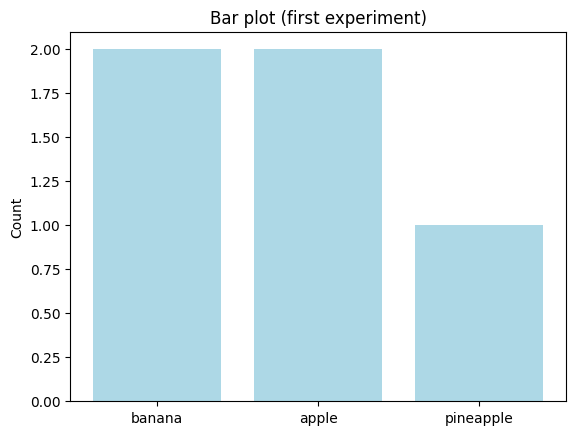

In [1]:
from sklearn_evaluation.plot._example import MyBar

bar = MyBar.from_raw_data(
    ["banana", "banana", "apple", "pineapple", "apple"],
    color="lightblue",
    name="first experiment",
)

The constructor must take aggregated data. End-users do not typically call the constructor directly; however, it's still part of the public API. Unlike our `from_raw_data`, the constructor takes aggregated data (the counts):

In [2]:
bar_second = MyBar({"banana": 3, "apple": 5, "pineapple": 2})

Plots implement a `.plot()` method where all the plotting logic happens:

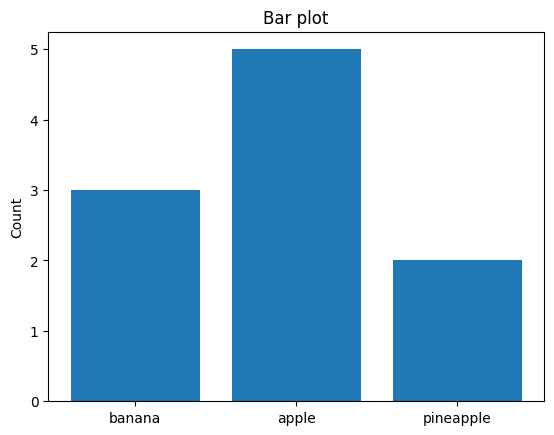

In [3]:
bar_second.plot()

### Addition

The plot might support the `+` operator, which should produce a combined plot to compare both plots (order might matter in some cases, but not always):

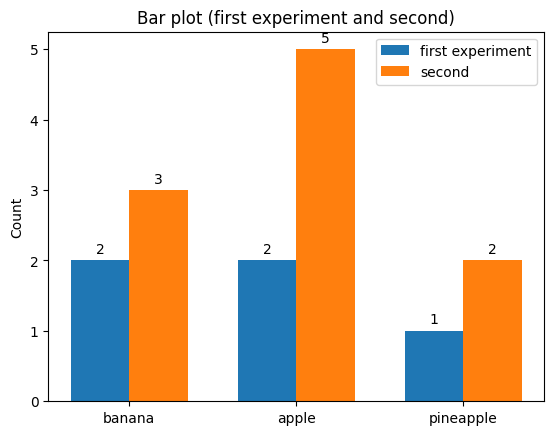

In [4]:
bar + bar_second

### Substraction

If it makes sense for your plot, you might add support for the `-` operator, which should create a combined plot to summarize results from two in individual plots:

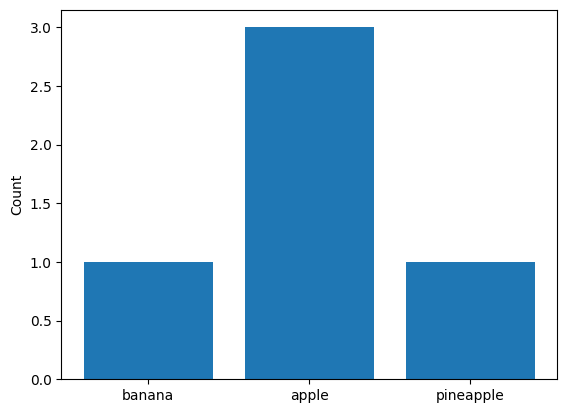

In [5]:
bar_second - bar

Note that order is important:

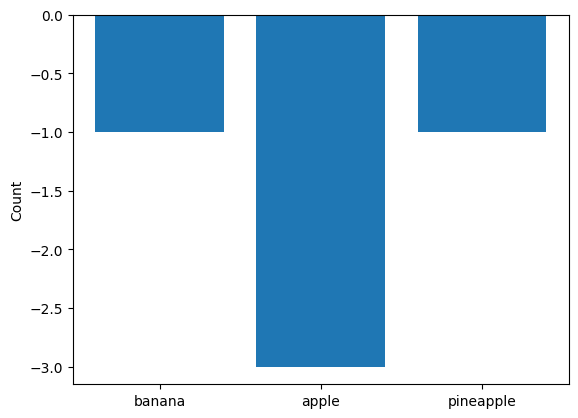

In [6]:
bar - bar_second

### Serialization

Plots should implement a private `_get_data()` method to return all necessary data required to re-create the plot:

In [7]:
bar._get_data()

{'class': 'sklearn_evaluation.plot._example.MyBarPlot',
 'count': {'banana': 2, 'apple': 2, 'pineapple': 1},
 'color': 'lightblue',
 'name': 'first experiment',
 'version': '0.11.4'}

A `.dump()` method to dump this data into a JSON file:

In [8]:
bar.dump("bar.json")

And a `from_dump()` class method to load a plot from a JSON file:

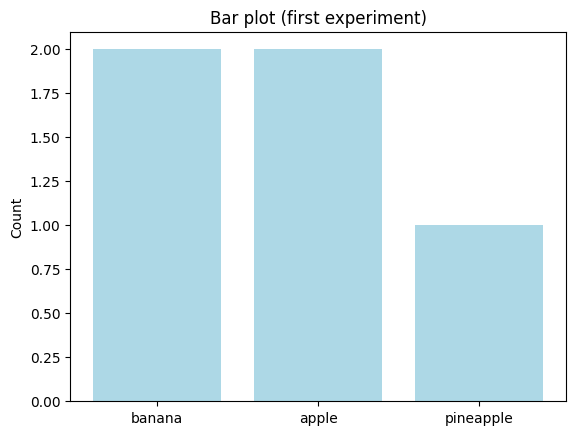

In [9]:
MyBar.from_dump("bar.json")

## Functional API

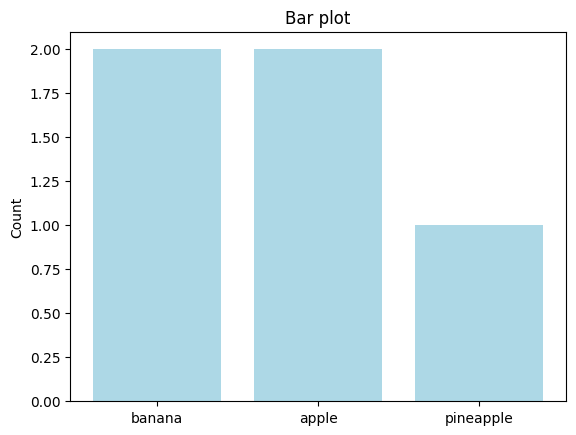

In [10]:
from sklearn_evaluation.plot._example import my_bar

result = my_bar(["banana", "banana", "apple", "pineapple", "apple"], color="lightblue")

In [11]:
type(result)

matplotlib.axes._axes.Axes

## Guidelines

```{tip}
For general guidelines, see [Ploombers' documentation framework.](https://github.com/ploomber/contributing/blob/main/documentation/README.md)
```

To provide a consistent user experience, all the functions that produce plots follow a few conventions.

### Classes and functions must be importable from `sklearn_evaluation.plot`

Add them to `src/sklearn_evaluation/plot/__init__.py`

### Do not set figure/text sizes

We should not hardcode figure or font sizes inside the plots; we should allow the user to decide on this.

### Classes/Functions should not contain `plot` in its name

Example:

```python
# not confusion_matrix plot!
def confusion_matrix(y_true, y_pred):
    pass

class ConfusionMatrix:
    pass
```

### Every argument except the input data should have default values

Example:

```python
class ConfusionMatrix:
    def __init__(self, cm, target_names=None):
        pass
    
    def from_raw_data(cls, y_true, y_pred, target_names=None):
        pass

def confusion_matrix(y_true, y_pred, target_names=None, ax=None):
    pass
```

### Follow the argument naming convention

Many of the functions take a vector of real values (first argument) and a vector of predicted values (second argument), they should be named `y_true` and `y_pred` respectively.

```python
def some_algorithm(y_true, y_pred, ..., ax=None):
    pass
```

See the [`confusion_matrix`](https://github.com/ploomber/sklearn-evaluation/blob/8056bc31ec5e372102d0ee5ada988e380b077c4b/src/sklearn_evaluation/plot/classification.py#L135) function for an example.

If the plotting function applies to classifiers (e.g., confusion matrix), and the raw scores from the models are the input (instead of the predicted class), the second argument should be named `y_score`:

```python
def some_algorithm(y_true, y_score, ..., ax=None):
    pass
```

See the [`precision_at_proportion`](https://github.com/ploomber/sklearn-evaluation/blob/8056bc31ec5e372102d0ee5ada988e380b077c4b/src/sklearn_evaluation/plot/classification.py#L309) function for an example.

In cases where the function doesn't take a true and predicted vector, the names should be descriptive enough:

```python
def some_algorithm(some_meaningful_name, ..., ax=None):
    pass
```

See the [`learning_curve`](https://github.com/ploomber/sklearn-evaluation/blob/8056bc31ec5e372102d0ee5ada988e380b077c4b/src/sklearn_evaluation/plot/learning_curve.py#L7) function for an example.

### Testing

Each function must have a corresponding test. If the function has parameters that alter the plot, they should be included as well as separate tests. See the [plot tests](https://github.com/ploomber/sklearn-evaluation/blob/master/tests/test_plot.py) here.

The first time you run the tests, it'll fail since there won't be baseline images to compare to. Example:

> OSError: Baseline image '/Users/eduardo/dev/sklearn-evaluation/result_images/test_bar/mybar-expected.png' does not exist.


Go to `result_images/{test_file_name}/{baseline_image_name}.png` and check if the plot is what you're expecting. If so, copy the image into: `tests/baseline_images/{test_file_name}/{baseline_image_name}.png`, then run the tests again, they should pass now.

For example tests, see `tests/test_bar.py`

### Documentation

The function must contain a docstring explaining what the function does and a description of each argument. [See this example.](https://github.com/ploomber/sklearn-evaluation/blob/8056bc31ec5e372102d0ee5ada988e380b077c4b/src/sklearn_evaluation/plot/classification.py#L143)

Furthermore, a full example (under the docstring's `Examples` section)must be included in the examples section of the docstring. Such an example must be standalone so that copy-paste should work. [See this example.](https://sklearn-evaluation.readthedocs.io/en/latest/api/plot.html#sklearn_evaluation.plot.confusion_matrix) Note that these examples are automatically tested by the CI.

Each function's docstring should also have a `Notes` section with a `.. versionadded::` to specify from which version this plot is available.
The current dev version of sklearn-evaluation can be found in [`here`](https://github.com/ploomber/sklearn-evaluation/blob/master/src/sklearn_evaluation/__init__.py). So, if current `dev` version is 0.0.1dev, the version of the next release will be 0.0.1.

Here's a docstring template you can use:

```python
def my_plotting_function(y_true, y_pred, ax=None):
    """Plot {plot name}

    Parameters
    ----------
    y_true : array-like, shape = [n_samples]
        Correct target values (ground truth).

    y_pred : array-like, shape = [n_samples]
        Target predicted classes (estimator predictions).

    ax: matplotlib Axes
        Axes object to draw the plot onto, otherwise uses current Axes

    Returns
    -------
    ax: matplotlib Axes
        Axes containing the plot

    Examples
    --------
    .. plot:: ../examples/{example-name}.py
    
    Notes
    -----
    .. versionadded:: 0.0.1
    """
    pass
```

## Guidelines (functional API)


### The last argument in the function must be `ax=None`

The last argument should be `ax=None`. If the user passes a value (a `matplotlib.axes.Axes` object), the plot must be created there. If not, we should use the default axes with `ax = plt.gca()`.

```python
def some_algorithm(a, b, ..., ax=None):
    pass
```

See the [`roc`](https://github.com/ploomber/sklearn-evaluation/blob/8056bc31ec5e372102d0ee5ada988e380b077c4b/src/sklearn_evaluation/plot/roc.py#L45) function for an example.

### Functions must return a `matplotlib.Axes` object

The `ax` object must be returned at the end of the function.

See the [`roc`](https://github.com/ploomber/sklearn-evaluation/blob/8056bc31ec5e372102d0ee5ada988e380b077c4b/src/sklearn_evaluation/plot/roc.py#L45) function for an example.

## Telemetry

Monitoring the state of `sklearn-evaluation`

Use [`SKLearnEvaluationLogger`](https://github.com/ploomber/sklearn-evaluation/blob/f32c15a43f4a9b4c2e588b3c0f71ba6dc5a71a7e/src/sklearn_evaluation/telemetry.py#L19) decorator to generate logs

Example:

```python
@SKLearnEvaluationLogger.log(feature='plot')
def confusion_matrix(
        y_true,
        y_pred,
        target_names=None,
        normalize=False,
        cmap=None,
        ax=None,
        **kwargs):
pass
```

this will generate the following log:

```json
        {
          "metadata": {
          "action": "confusion_matrix"
          "feature": "plot",
          "args": {
                        "target_names": "None",
                        "normalize": "False",
                        "cmap": "None",
                        "ax": "None"
                    }
          }
        }
```

\*\* since `y_true` and `y_pred` are positional arguments without default values it won't log them

### Queries

1. Run queries and filter out `sklearn-evaluation` events by the event name: `sklearn-evaluation`
2. Break these events by feature ('plot', 'report', 'SQLiteTracker', 'NotebookCollection')
3. Break events by actions/func name (i.e: 'confusion_matrix', 'roc', etc...)

### Errors

Failing runnings will be named: `sklearn-evaluation-error`